In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from utils.utils import get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, transform_points_to_original_space
from utils.utils import create_scalarmappable, plot_scalebar, calculate_average_image, translate_images_to_mean_keypoint, subtract_average_image
from utils.egocentric_utils import process_images_with_extents, process_images_with_masks, plot_colorline
from utils.piv_utils import plot_bbox
#from utils.utils import plot_scalebarxy

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

- is this Dmid ???

In [3]:
vid_path = "../data/videos/feature-extraction/"
vid_filename = "2024_0201_152845_091_subclip_7sec_ts98-te105_cropped.mp4"
vid_props = get_video_properties(vid_path, vid_filename)
fps, num_frames, img_width, img_height = get_video_properties(vid_path, vid_filename)
print(vid_props) # ["filename", "fps", "num_frames", "width", "height"]

# Scale D-high
mpp = 2.5  # microns_per_pixel
print("D high - UHD")
fig_params = {"dpi" : 600, "bbox_inches" : "tight"}

# export frames if necessary
EXPORT_FRAMES = False
export_frames = np.arange(0, num_frames, 2) # resample to 30 fps
img_save_dir = f"../data/images/{vid_filename.split('.')[0]}/"
export_selected_frames(os.path.join(vid_path, vid_filename), img_save_dir, export_frames) if EXPORT_FRAMES else None

# IMAGES
img_filenames = sorted([fn for fn in os.listdir(img_save_dir) if fn.endswith("jpg")])
img_filepaths = [os.path.join(img_save_dir, fn) for fn in img_filenames]

# CREATE! mask filenames based every second image frame exported
masks_dir = f"../data/seg_masks/{vid_filename.split('.')[0]}_masks/"
mask_filenames = sorted([fn for fn in os.listdir(masks_dir) if fn.endswith("png")])
mask_filepaths = [os.path.join(masks_dir, fn) for fn in mask_filenames]

print(len(mask_filepaths), len(img_filepaths))

(24, 168, 1530, 550)
D high - UHD
168 168


In [9]:
# Get contours from masks
contour_list = get_contours_from_segmasks(mask_filepaths)

# Get contour stats
df_stats = get_contour_stats(contour_list, min_area=1200)

# Add infos to dataframe
df_stats["time"] = df_stats.index.values / fps
df_stats[["img_fp", "mask_fp"]] = pd.DataFrame({'img_fp': img_filepaths, 'mask_fp': mask_filepaths})

# Check corresponding lengths
print(len(contour_list), len(mask_filepaths), len(df_stats))
print("centroid isNaN:", df_stats["centroid_x"].isna().sum())

save_path = f"../data/results/egocentric/{vid_filename.split('.')[0]}"
os.makedirs(save_path, exist_ok=True)

168 168 168
centroid isNaN: 3


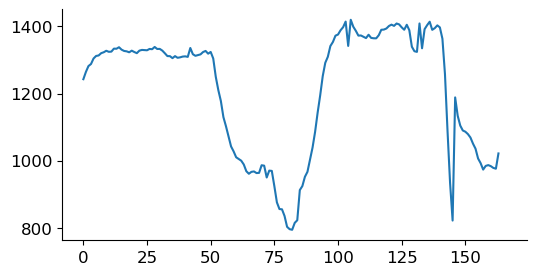

In [10]:
plt.plot(df_stats.perimeter)

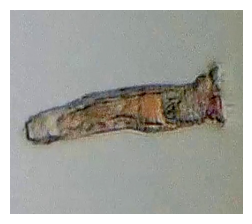

In [5]:

SAVE_FIGURES = False

img = cv2.cvtColor(cv2.imread(os.path.join("../data/images/", "frame_00060_cut.jpg")), cv2.COLOR_BGR2RGB)
ax_params = dict(xlim=(0, img.shape[1]), ylim=(0, img.shape[0]))

fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(img)
#plot_scalebar(ax=ax, mpp=mpp, width_microns=50, position=(30,350), linewidth=3, fontsize=10)
ax.set(**ax_params); ax.axis("off"); ax.invert_yaxis()
fig.savefig(f"{save_path}/Illustration_frame_00060_cut.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

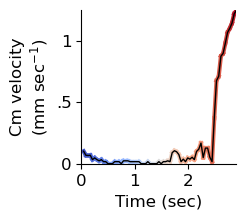

In [6]:
SAVE_FIGURES = False
df_stats = df_stats[:71]
# Get frames and noralized perimeter
variables = ["time", "perimeter", "centroid_dist", "orientation"]
time, perimeter, dcm, orient = df_stats[variables].values.T
nperimeter = perimeter #/ mpp


tc, _ = create_scalarmappable("coolwarm", np.arange(0, len(time)))

fig, ax = plt.subplots(figsize=(2,2))
plot_colorline(time, dcm / mpp * (1000/fps) / 1000, colors=tc, ax=ax, lw=3)
ax.plot(time, dcm / mpp * (1000/fps) / 1000, "-k", lw=1)
ax.set(xlabel="Time (sec)", ylabel="Cm velocity\n(mm sec$^{-1}$)", xlim=(0, max(time)), ylim=(0,1.25), yticks=[0,.5,1], yticklabels=["0", ".5", "1"]);

fig.savefig(f"{save_path}/velocity_versus_time.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

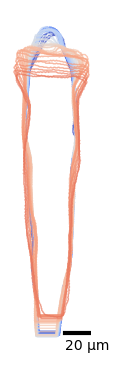

In [7]:
# setup params
centers = list(df_stats.loc[:, ["centroid_x", "centroid_y"]].itertuples(index=False, name=None))
rot_angles = df_stats["orientation"].values
masks_illustrate = df_stats["mask_fp"].to_list()

# operate on masks and contours
rot_masks, rot_contours = rotate_masks_and_contours(centers, rot_angles, masks_illustrate)
df_top_bot = pd.DataFrame(find_top_bottom_points_from_contours(rot_contours))
centered_contours = normalize_contours_by_centers(rot_contours, centers) 

idx = np.arange(0, 59, 1)
fig, ax = plt.subplots(figsize=(3,4.5))
for nth, rcnt in enumerate(centered_contours[:59]):
    x,y = rcnt.squeeze().T
    ax.plot(x, -y, "-", lw=1, alpha=.7, color=tc[idx[nth]])
plot_scalebar(ax=ax, mpp=mpp, width_microns=20, position=(25,-260), linewidth=3, fontsize=10)

ax.set(xlim=(-70, 70), ylim=(-300, 300))
ax.set_aspect("equal"); ax.set_axis_off();#ax.invert_yaxis();
fig.savefig(f"{save_path}/stance-unfurl-overlay.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None

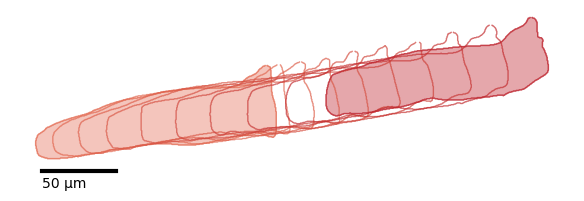

In [8]:
# frames 23-50 unfurl, 51-59 crouch, 60 take off, 60-69 flying
# did overwrite frame60 > export selected frames function!
# is it possible to zoom into unfurling? or show only start frame and then continue later BUT KEEP APPROPRIATE TIME CODE
# zoom in images (like the above, as they are not good enough for example images), that accompany the timeline
every_nth = 1
idx = np.arange(59, 69, 1)

contour_list_ = [contour_list[i] for i in idx]#contour_list[59:69] # [:69]
subcontours = contour_list_[::every_nth]
#tcolors, _ = create_scalarmappable("coolwarm", range(len(subcontours)), (0, len(subcontours)))

fig, ax = plt.subplots(figsize=(6,3))
for nth, rcnt in enumerate(subcontours):
    x,y = rcnt.squeeze().T
    ax.plot(x, -y, "-", lw=1, alpha=.7, color=tc[idx[nth]])
    if (nth==0) | (nth==len(subcontours)-1):
        ax.fill(x, -y, color=tc[idx[nth]], alpha=0.4)
    
for spine in ax.spines.values():
    spine.set_visible(True)

plot_scalebar(ax=ax, mpp=mpp, width_microns=50, position=(280,-400), linewidth=3, fontsize=10)
ax.set_aspect("equal"); ax.set_axis_off(); plt.tight_layout()#ax.invert_yaxis()
fig.savefig(f"{save_path}/Contour-overlay_swim_time_color_code.jpg", dpi=600, bbox_inches="tight") if SAVE_FIGURES else None